# TASD-Dataset: Text-based Early ASD Detection

#### About Dataset
The TASD-Dataset is tailored for early ASD detection in toddlers, providing detailed textual sequences that describe the daily situations of toddlers both with and without ASD. It incorporates essential ASD assessment features such as Attention Response, Word Repetition, Emotional Empathy, and introduces new features including Noise Sensitivity, Sharing Interest, Sign Communication, and Tiptoe Flapping. Each feature is intricately linked with specific toddler behaviors, offering nuanced insights for parents and aiding in the identification of ASD-related signals. By emphasizing these features, the dataset facilitates the development of machine learning models to explore behavioral markers crucial for early ASD risk detection.

In [152]:
#imports
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.layers import Layer
import keras.backend as K
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, LSTM
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Embedding
from keras import Model
from keras.layers import Flatten, Input, Layer, GlobalMaxPooling1D, LSTM, Bidirectional, Concatenate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [153]:
tweets = pd.read_csv('Checkpoint2.csv')

In [154]:
tweets.loc[tweets["ASD"]=="ASD","ASD"] = 1

In [155]:
tweets.loc[tweets["ASD"]=="Non-ASD","ASD"] = 0

In [156]:
tweets.columns

Index(['Text', 'Class', 'Sign', 'ASD', 'char_len', 'word_len', 'sent_len',
       'polarity', 'subjectivity', 'exclaimation_num', 'questionmark_num',
       'url_num', 'hash_num', 'mention_num', 'contraction_num',
       'text_nostopwords'],
      dtype='object')

## Train Validation Data Split

In [157]:
X_train, X_val, y_train, y_val = train_test_split(tweets.drop(['Class','Sign','ASD',"text_nostopwords"],axis=1), tweets[['ASD']], test_size=0.2, stratify=tweets[['ASD']], random_state=42)
X_train_text = X_train['Text']
X_val_text = X_val['Text']

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (265, 12)
X_val shape:  (67, 12)
y_train shape:  (265, 1)
y_val shape:  (67, 1)


In [158]:
print('Train Class Proportion:\n', y_train['ASD'].value_counts() / len(y_train) * 100)
print('\nValidation Class Proportion:\n', y_val['ASD'].value_counts() / len(y_val) * 100)

Train Class Proportion:
 ASD
1    52.45283
0    47.54717
Name: count, dtype: float64

Validation Class Proportion:
 ASD
1    52.238806
0    47.761194
Name: count, dtype: float64


## Tokenization

In [159]:
tokenizer_1 = Tokenizer(num_words=5000, oov_token='<UNK>')
tokenizer_1.fit_on_texts(X_train_text)

In [160]:
X_train_text = tokenizer_1.texts_to_sequences(X_train_text)
X_val_text = tokenizer_1.texts_to_sequences(X_val_text)
print(X_train_text[:10])
print('')
print(X_val_text[:10])

[[101, 4, 88, 40, 2, 355, 3, 136, 51, 356, 461, 21, 11, 4, 203, 40, 3, 204, 8, 37, 462, 62, 101, 205, 357, 118, 25, 3, 301, 51], [13, 302, 8, 206, 207, 41, 15, 303, 18, 8, 463, 89, 6, 83, 5, 52, 21], [3, 175, 2, 19, 10, 47, 3, 23, 53, 33, 11, 243, 17, 15, 2, 244, 35, 6, 76, 46], [14, 4, 43, 27, 40, 9, 7, 4, 102, 2, 66, 10, 137, 15, 245, 5, 128, 66, 26, 67, 119, 22, 2, 84, 5, 158, 358], [14, 44, 27, 34, 208, 40, 9, 7, 10, 159, 2, 19, 30, 11, 68, 176, 129, 6, 69, 5, 24, 45], [246, 3, 247, 2, 160, 37, 26, 4, 209, 31, 10, 210, 11, 30, 304, 5, 305], [16, 9, 7, 4, 66, 102, 77, 161, 2, 211, 464, 120, 30, 66, 359, 360, 5, 361, 248, 41, 15, 212, 89, 6, 121, 55], [130, 12, 111, 122, 10, 48, 9, 7, 4, 28, 2, 131, 25, 31, 38, 3, 23, 53, 8, 177], [20, 138, 132, 32, 31, 10, 139, 362, 13, 465, 111, 17, 466, 8, 249, 13, 63, 213], [31, 10, 363, 9, 7, 4, 56, 25, 58, 42, 30, 13, 130, 12, 16, 5, 43, 17, 31, 85]]

[[142, 10, 4, 13, 23, 367, 368, 2, 79, 64, 54, 9, 7, 68, 254, 178, 5, 162, 104, 369, 370, 25, 

In [161]:
tokenizer_1.sequences_to_texts([X_train_text[1]])

['a structure and organize environment help them stay focus and perform better in task or learn activities']

## Padding

In [162]:
print('Train Set Max Length:', max(len(text) for text in X_train_text))
maxlen = 50

X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_val_text = pad_sequences(X_val_text, padding='post', maxlen=maxlen)

print('X_train shape:', X_train_text.shape)
print('X_train shape:', X_val_text.shape)

Train Set Max Length: 43
X_train shape: (265, 50)
X_train shape: (67, 50)


## Embedding Matrix – GloVe

We will use the [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) that were pre-trained on 2 billion tweets to create our feature matrix. First, we will create a dictionary that will contain words as keys and their corresponding embedding list at values. The length of the embedding for each word will be 200, as the GloVe embedding we are using was trained to have 200 dimensions. Refer to [here](https://github.com/stanfordnlp/GloVe) also for more details.



In [163]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer_1.word_index) + 1

# load the whole embedding into memory
embeddings_index = dict()
f = open(r'E:\Bioinfo\NaturalLanguageProcessing-Healthcare\glove.2024.dolma.300d\dolma_300_2024_1.2M.100_combined.txt', "r", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1200001 word vectors.


Next we will create an embedding matrix for our train vocab/corpus where each row number will correspond to the index of the word in our train vocab/corpus. The matrix will have 200 columns, each containing one of the GloVe feature/dimension.

In [165]:
# create a weight matrix for words in training set
#embedding_matrix = np.zeros((vocab_size, 200))
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer_1.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('Embedding Matrix Shape:', embedding_matrix.shape)

Embedding Matrix Shape: (671, 300)


## LSTM

In [166]:
## Hyperparameters
num_epochs=25
dropout=0.2
recurrent_dropout=0.2
lr=0.0005
batch_size=50
#class_weight = {0: y_train['ASD'].value_counts()[1]/len(y_train), 1: y_train['ASD'].value_counts()[0]/len(y_train)} 

In [167]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
lstm_model.add(LSTM(32, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
lstm_model.add(LSTM(8, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
lstm_model.add(LSTM(8))

lstm_model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=lr)
lstm_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 50, 300)           201300    
                                                                 
 lstm_56 (LSTM)              (None, 50, 128)           219648    
                                                                 
 lstm_57 (LSTM)              (None, 50, 32)            20608     
                                                                 
 lstm_58 (LSTM)              (None, 50, 8)             1312      
                                                                 
 lstm_59 (LSTM)              (None, 8)                 544       
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 443421 (1.69 MB)
Trainable params: 2421

In [168]:
def plot_model_performance(history):   
    plt.figure(figsize=(15,5))
    plt.plot(range(num_epochs), history.history['acc'],'-o',
             label='Train ACC',color='#ff7f0e')
    plt.plot(range(num_epochs),history.history['val_acc'],'-o',
             label='Val ACC',color='#1f77b4')
    x = np.argmax( history.history['val_acc'] ); y = np.max( history.history['val_acc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
    plt.ylabel('Accuracy',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=(0.01,0.75))

    plt2 = plt.gca().twinx()
    plt2.plot(range(num_epochs),history.history['loss'],'-o',
              label='Train Loss',color='#2ca02c')
    plt2.plot(range(num_epochs),history.history['val_loss'],'-o',
              label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
   # plt.ylim([-0.2, 2])
    plt.ylabel('Loss',size=14)
    plt.xticks(ticks=list(range(num_epochs)),labels=list(range(1, num_epochs+1)))
    plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1))
    plt.show()

In [169]:
X_train_text = tf.convert_to_tensor(X_train_text)
X_val_text = tf.convert_to_tensor(X_val_text)

y_train = np.asarray(y_train, dtype=np.int32)
y_val   = np.asarray(y_val, dtype=np.int32)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

In [ ]:
checkpoint = ModelCheckpoint('lstm_model.keras', monitor='val_accuracy', save_best_only=True)

history = lstm_model.fit(X_train_text, y_train, batch_size=batch_size, callbacks=[checkpoint], epochs=num_epochs, 
                         validation_data=(X_val_text, y_val), verbose=1)
plot_model_performance(history)

Epoch 1/25
6/6 [==============================] - 26s 2s/step - loss: 0.6885 - acc: 0.5057 - val_loss: 0.6903 - val_acc: 0.5224
Epoch 2/25
6/6 [==============================] - 2s 319ms/step - loss: 0.6802 - acc: 0.5245 - val_loss: 0.6914 - val_acc: 0.5373
Epoch 3/25
6/6 [==============================] - 2s 437ms/step - loss: 0.6757 - acc: 0.5547 - val_loss: 0.6858 - val_acc: 0.6269
Epoch 4/25
6/6 [==============================] - 2s 370ms/step - loss: 0.6648 - acc: 0.6151 - val_loss: 0.6750 - val_acc: 0.6567
Epoch 5/25
6/6 [==============================] - 2s 318ms/step - loss: 0.6515 - acc: 0.6377 - val_loss: 0.6524 - val_acc: 0.6716
Epoch 6/25
6/6 [==============================] - 2s 381ms/step - loss: 0.5942 - acc: 0.7623 - val_loss: 0.6213 - val_acc: 0.6269
Epoch 7/25
6/6 [==============================] - 2s 358ms/step - loss: 0.5906 - acc: 0.6981 - val_loss: 0.6313 - val_acc: 0.6567
Epoch 8/25
6/6 [==============================] - 2s 368ms/step - loss: 0.5938 - acc: 0.7245

Epoch 1/25
6/6 [==============================] - 17s 528ms/step - loss: 0.6917 - acc: 0.5245 - val_loss: 0.6900 - val_acc: 0.5224
Epoch 2/25
6/6 [==============================] - 1s 202ms/step - loss: 0.6858 - acc: 0.5283 - val_loss: 0.6896 - val_acc: 0.5373
Epoch 3/25
6/6 [==============================] - 1s 206ms/step - loss: 0.6793 - acc: 0.5283 - val_loss: 0.6869 - val_acc: 0.5224
Epoch 4/25
6/6 [==============================] - 1s 198ms/step - loss: 0.6721 - acc: 0.5358 - val_loss: 0.6771 - val_acc: 0.5821
Epoch 5/25
6/6 [==============================] - 1s 192ms/step - loss: 0.6452 - acc: 0.6830 - val_loss: 0.6329 - val_acc: 0.6567
Epoch 6/25
6/6 [==============================] - 1s 198ms/step - loss: 0.5865 - acc: 0.7698 - val_loss: 0.5804 - val_acc: 0.7463
Epoch 7/25
6/6 [==============================] - 1s 194ms/step - loss: 0.5389 - acc: 0.8189 - val_loss: 0.7013 - val_acc: 0.5075
Epoch 8/25
6/6 [==============================] - 1s 189ms/step - loss: 0.6196 - acc: 0.6

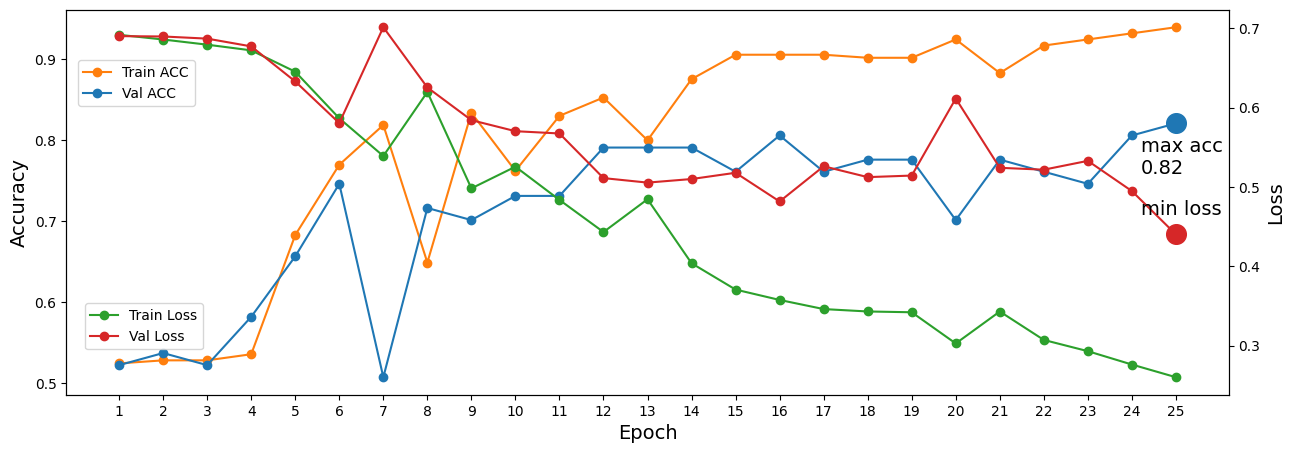

In [132]:
checkpoint = ModelCheckpoint('lstm_model.keras', monitor='val_accuracy', save_best_only=True)

history = lstm_model.fit(X_train_text, y_train, batch_size=batch_size, callbacks=[checkpoint], epochs=num_epochs, 
                         validation_data=(X_val_text, y_val), verbose=1)
plot_model_performance(history)

## Bidirectional LSTM with Attention

In [133]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1] 
        self.W = self.add_weight(name="att_weight",
                                 shape=(feature_dim, 1),
                                 initializer="glorot_normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(1,),  
                                 initializer="zeros",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.matmul(x, self.W) + self.b) 
        at = tf.nn.softmax(et, axis=1) 

        output = x * at 
        return tf.reduce_sum(output, axis=1) 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super(Attention, self).get_config()
        return config

In [149]:
num_epochs=50
dropout=0.3
recurrent_dropout=0.3
lr=0.0005
batch_size=50

In [150]:
## Embedding Layer
sequence_input = Input(shape=(maxlen,))
embedded_sequences = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(sequence_input)

## RNN Layer
lstm = Bidirectional(LSTM(128, return_sequences = True, dropout=dropout, recurrent_dropout=recurrent_dropout))(embedded_sequences)
lstm = Bidirectional(LSTM(128, return_sequences = True, dropout=dropout, recurrent_dropout=recurrent_dropout))(embedded_sequences)
# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(128, return_sequences=True, return_state=True))(lstm)

## Attention Layer
att_out = Attention()(lstm)

outputs=Dense(1,activation='sigmoid')(att_out)
model_attn = Model(sequence_input, outputs)

adam = optimizers.Adam(learning_rate=lr)

model_attn.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

print(model_attn.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_19 (Embedding)    (None, 50, 200)           134200    
                                                                 
 bidirectional_16 (Bidirect  (None, 50, 256)           336896    
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  [(None, 50, 256),         394240    
 ional)                       (None, 128),                       
                              (None, 128),                       
                              (None, 128),                       
                              (None, 128)]                       
                                                           

Epoch 1/50
6/6 [==============================] - 16s 645ms/step - loss: 0.6980 - acc: 0.5170 - val_loss: 0.6856 - val_acc: 0.5224
Epoch 2/50
6/6 [==============================] - 2s 277ms/step - loss: 0.6785 - acc: 0.6189 - val_loss: 0.6763 - val_acc: 0.6418
Epoch 3/50
6/6 [==============================] - 2s 297ms/step - loss: 0.6576 - acc: 0.7811 - val_loss: 0.6489 - val_acc: 0.6866
Epoch 4/50
6/6 [==============================] - 2s 269ms/step - loss: 0.5917 - acc: 0.7358 - val_loss: 0.5653 - val_acc: 0.7463
Epoch 5/50
6/6 [==============================] - 1s 233ms/step - loss: 0.4618 - acc: 0.8151 - val_loss: 0.5820 - val_acc: 0.7463
Epoch 6/50
6/6 [==============================] - 2s 281ms/step - loss: 0.4126 - acc: 0.8415 - val_loss: 0.5822 - val_acc: 0.7612
Epoch 7/50
6/6 [==============================] - 2s 269ms/step - loss: 0.3337 - acc: 0.8642 - val_loss: 0.4895 - val_acc: 0.7761
Epoch 8/50
6/6 [==============================] - 1s 234ms/step - loss: 0.2842 - acc: 0.9

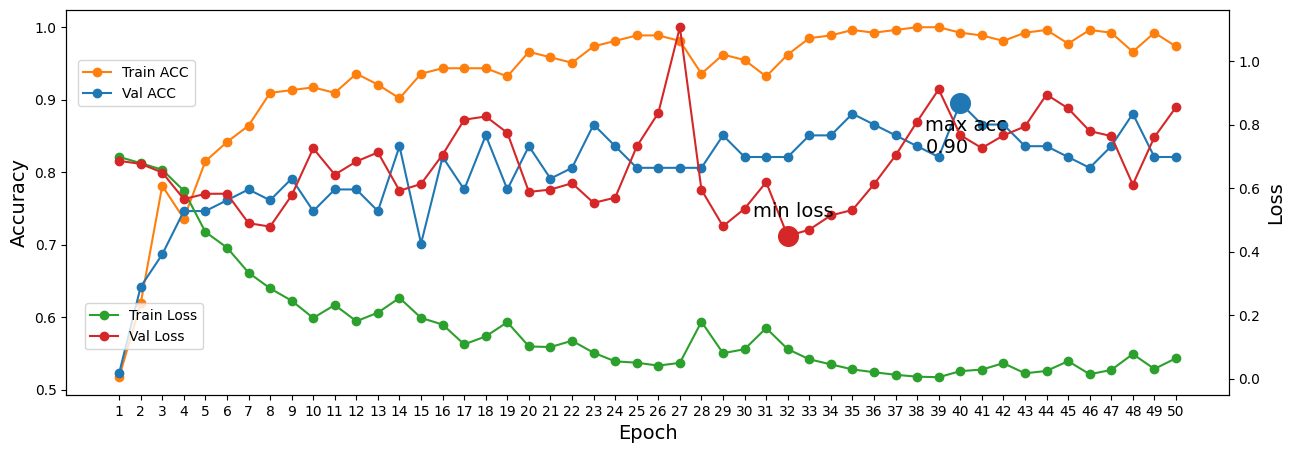

In [151]:
checkpoint = ModelCheckpoint('attn_model.keras', monitor='val_acc', save_best_only=True)
history_attn = model_attn.fit(X_train_text, y_train, batch_size=batch_size, callbacks=[checkpoint], epochs=num_epochs, 
                              validation_data=(X_val_text, y_val), verbose=1)
plot_model_performance(history_attn)